# Explore and visualize case studies
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria

## Python setup

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shash
from build_data import build_hurricane_data
import build_model
import model_diagnostics
from silence_tensorflow import silence_tensorflow
import prediction
from sklearn.neighbors import KernelDensity
import pandas as pd
from tqdm import tqdm
import analysis_plots
from scipy import stats
from toolbox import custom_round, ceiling_round
import seaborn as sns

import imp
import warnings
warnings.filterwarnings("ignore")
silence_tensorflow()
dpiFig = 400

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## User parameters

In [2]:
__author__  = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "19 March 2022"

EXP_NAME = "intensity201_AL24"
LEADTIME = 24
TESTING_YEAR = 2018
STORM_NAME = "ISAAC"


SHASH_INCS = np.arange(-160,161,1)
DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
FIGURE_PATH = "figures/paper_figures/"
PREDICTION_PATH = "saved_predictions/"

In [3]:
RI_THRESH_DICT = {24: 30,
                  48: 55,
                  72: 65,
                 }

df_bestval = pd.read_pickle(PREDICTION_PATH + "best_shash3_validation_seeds.pickle")
df = df_bestval[df_bestval["basin_lead"]==EXP_NAME[EXP_NAME.rfind('_')+1:]]
RNG_SEED = df[df["testing_years"]==TESTING_YEAR]["rng_seed"][0]

## Plotting functions

In [4]:
FS = 16
colors = ('#284E60','#E1A730','#D95980','#C3B1E1','#351F27','#A9C961')

### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

In [5]:
def get_storm_details(df, isample):
    storm = df.iloc[isample]
    storm_name = storm['Name']
    storm_ftime = storm['ftime(hr)']
    storm_month = str(storm['time'])[:-4]
    storm_day = str(storm['time'])[-4:-2]
    storm_hour = str(storm['time'])[-2:]
    storm_year = storm['year']

    details = storm_name + ' ' + str(storm_year) + '-' + str(storm_month) + '-' + str(storm_day) + ' ' + str(storm_hour) + '00 @' + str(storm_ftime) + 'hr'
    
    return details

In [6]:
def plot_iqr_vs_error(ax,model, x_eval, onehot_eval, df_eval, yvar="shash_error"):
    # make predictions
    mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params(x_eval, model)    

    # convert y_pred to intensity corrections    
    ann_correction  = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.5)
    true_correction = df_eval['OBDV'].to_numpy()  

    # convert to full intensity predictions
    cons_intensity  = df_eval['VMXC'].to_numpy()
    ann_intensity   = cons_intensity + ann_correction
    true_intensity  = cons_intensity + true_correction

    # compute errors
    shash_error  = np.abs(ann_intensity - true_intensity)
    cons_error = np.abs(cons_intensity - true_intensity)

    # covert shash prediction bounds
    shash_low_correction  = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.25)
    shash_high_correction = prediction.percentile_value(mu_pred,sigma_pred,gamma_pred,tau_pred,percentile_frac=.75)
    iqr                   = shash_high_correction - shash_low_correction

    print(stats.spearmanr(iqr,shash_error))
    print(stats.pearsonr(iqr,shash_error))

    df_eval['iqr'] = iqr
    df_eval['shash_error'] = shash_error
    df_eval['cons_error'] = cons_error

    #------------------------------------------------------------------------------------
    ROUND_BASE = 10

    df_plot = df_eval.copy()
    df_plot['iqr'] = pd.Series(df_plot['iqr']).apply(lambda x: custom_round(x, base=ROUND_BASE))
    df_plot['iqr'] = pd.Series(df_plot['iqr']).apply(lambda x: ceiling_round(x, ceiling=30))
    #-----------------------------------------------------------------------------
    clr = colors[0]
    if(yvar=="cons_error"):
        clr =colors[1]
    
    for xvar in ('iqr',):#('sigma', 'range_66'):
        g = sns.boxplot(
            ax=ax,
            data=df_plot,
            x=xvar, y=yvar,
            whis=None,
            fliersize=0,
            boxprops={'alpha':.2,
                      'edgecolor': 'gray',
                      'color': 'gray',
                     },
        )      
        plt.setp(g.artists, edgecolor = '.4', facecolor='.95')
        plt.setp(g.lines, color='.4')
        ax = sns.stripplot(ax=ax,x=xvar, y=yvar, data=df_plot, color=clr, size=3.,alpha=.75,)
        # plt.axhline(y=0,color='k', alpha=.25, linewidth=1)

        # g.set_xlim(-.5,6.5)

        ax.set_xlabel('ANN Predicted IQR [knots]')
        if(yvar=="cons_error"):
            ax.set_title('(c) Consensus Error vs ANN Predicted Uncertainty', fontsize=FS, color='k')    
            ax.set_ylabel('Consensus Absolute Error [knots]')
        else:
            ax.set_title('(b) ANN Error vs ANN Predicted Uncertainty', fontsize=FS, color='k')            
            ax.set_ylabel('ANN Absolute Error [knots]')        



## Network functions

In [7]:
def load_model():
    model_name = (
        EXP_NAME + "_" + 
        str(TESTING_YEAR) + '_' +
        settings["uncertainty_type"] + '_' + 
        f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
    )
    pprint.pprint(model_name)
    
    if settings["uncertainty_type"] == "bnn":       
        model = build_model.build_bnn_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            act_fun=settings["act_fun"],
        )
        
    elif settings["uncertainty_type"] == "mcdrop":       
        model = build_model.build_mcdrop_model(
            x_train,
            onehot_train,
            dropout_rate=settings["dropout_rate"],                
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            act_fun=settings["act_fun"],
        )

    elif settings["uncertainty_type"][:5] == "shash": 
        model = build_model.build_shash_model(
            x_train,
            onehot_train,
            hiddens=settings["hiddens"],
            output_shape=onehot_train.shape[1],
            ridge_penalty=settings["ridge_param"],
            act_fun=settings["act_fun"],
        )
        
    model.load_weights(MODEL_PATH + model_name + "_weights.h5")
        
    return model, model_name

In [8]:
def get_predictions(model, x_eval):
    runs = 5_000
    shash_cpd = np.zeros((np.shape(x_eval)[0],len(SHASH_INCS)))
    shash_med = np.zeros((np.shape(x_eval)[0],))
    mc_cpd = np.zeros((np.shape(x_eval)[0],runs))
    tf.random.set_seed(network_seed)

    if settings["uncertainty_type"] == "bnn":               
        for i in tqdm(range(0,runs)):
            mc_cpd[:,i] = np.reshape(model.predict(x_eval),np.shape(mc_cpd)[0])
        return mc_cpd, np.median(mc_cpd,axis=1)
    
    elif settings["uncertainty_type"] == "mcdrop":  
        # loop through runs for mcdrop calculation  
        for i in tqdm(range(0,runs)):
            mc_cpd[:,i] = np.reshape(model(x_eval,training=True),np.shape(mc_cpd)[0])    
        return mc_cpd, np.median(mc_cpd,axis=1)
    
    elif settings["uncertainty_type"][:5] == "shash": 
        # loop through samples for shash calculation and get PDF for each sample
        for j in tqdm(range(0,np.shape(shash_cpd)[0])):
            mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params( x_eval[np.newaxis,j], model )
            shash_cpd[j,:] = shash.prob(SHASH_INCS, mu_pred, sigma_pred, gamma_pred, tau_pred)    
            shash_med[j]   = shash.median(mu_pred,sigma_pred,gamma_pred,tau_pred)
        return shash_cpd, shash_med
    
    else:
        raise NotImplementedError('no such uncertainty type')


## Load the models

In [9]:
pred_dict = {}

settings = experiment_settings.get_settings(EXP_NAME)
settings["years_test"] = (TESTING_YEAR,)
settings['rng_seed'] = RNG_SEED
seed_dict = {}

NETWORK_SEED_LIST = [settings["rng_seed"]]
network_seed = NETWORK_SEED_LIST[0]
tf.random.set_seed(network_seed)  # This sets the global random seed.  

# get the data
(
    data_summary,        
    x_train,
    onehot_train,
    x_val,
    onehot_val,
    x_test,
    onehot_test,        
    x_valtest,
    onehot_valtest,
    df_train,
    df_val,
    df_test,
    df_valtest,
) = build_hurricane_data(DATA_PATH, settings, verbose=0)
# x_eval, onehot_eval, df_eval = x_test, onehot_test, df_test

# load the correct model
model, model_name = load_model()

# get predictions
pred_test = get_predictions(model, x_test)
pred_valtest = get_predictions(model, x_valtest)

seed_dict[network_seed] = {'pred_cpd_test': pred_test[0], 
                           'pred_med_test': pred_test[1],
                           'pred_cpd_valtest': pred_valtest[0], 
                           'pred_med_valtest': pred_valtest[1], 
                          }    
pred_dict[EXP_NAME] = seed_dict

print(pred_dict.keys())
# pred_dict['paper1_EPCP96'][605]['pred_cpd']

'intensity201_AL24_2018_shash3_network_seed_333_rng_seed_333'


100%|███████████████████████████████████████████████████████████████████████████████| 504/504 [00:06<00:00, 80.07it/s]

dict_keys(['intensity201_AL24'])


## Plot single network results

SpearmanrResult(correlation=0.3072231392409336, pvalue=1.7730775792844498e-12)
(0.2964638781860933, 1.1031321936007757e-11)
SpearmanrResult(correlation=0.3072231392409336, pvalue=1.7730775792844498e-12)
(0.2964638781860933, 1.1031321936007757e-11)


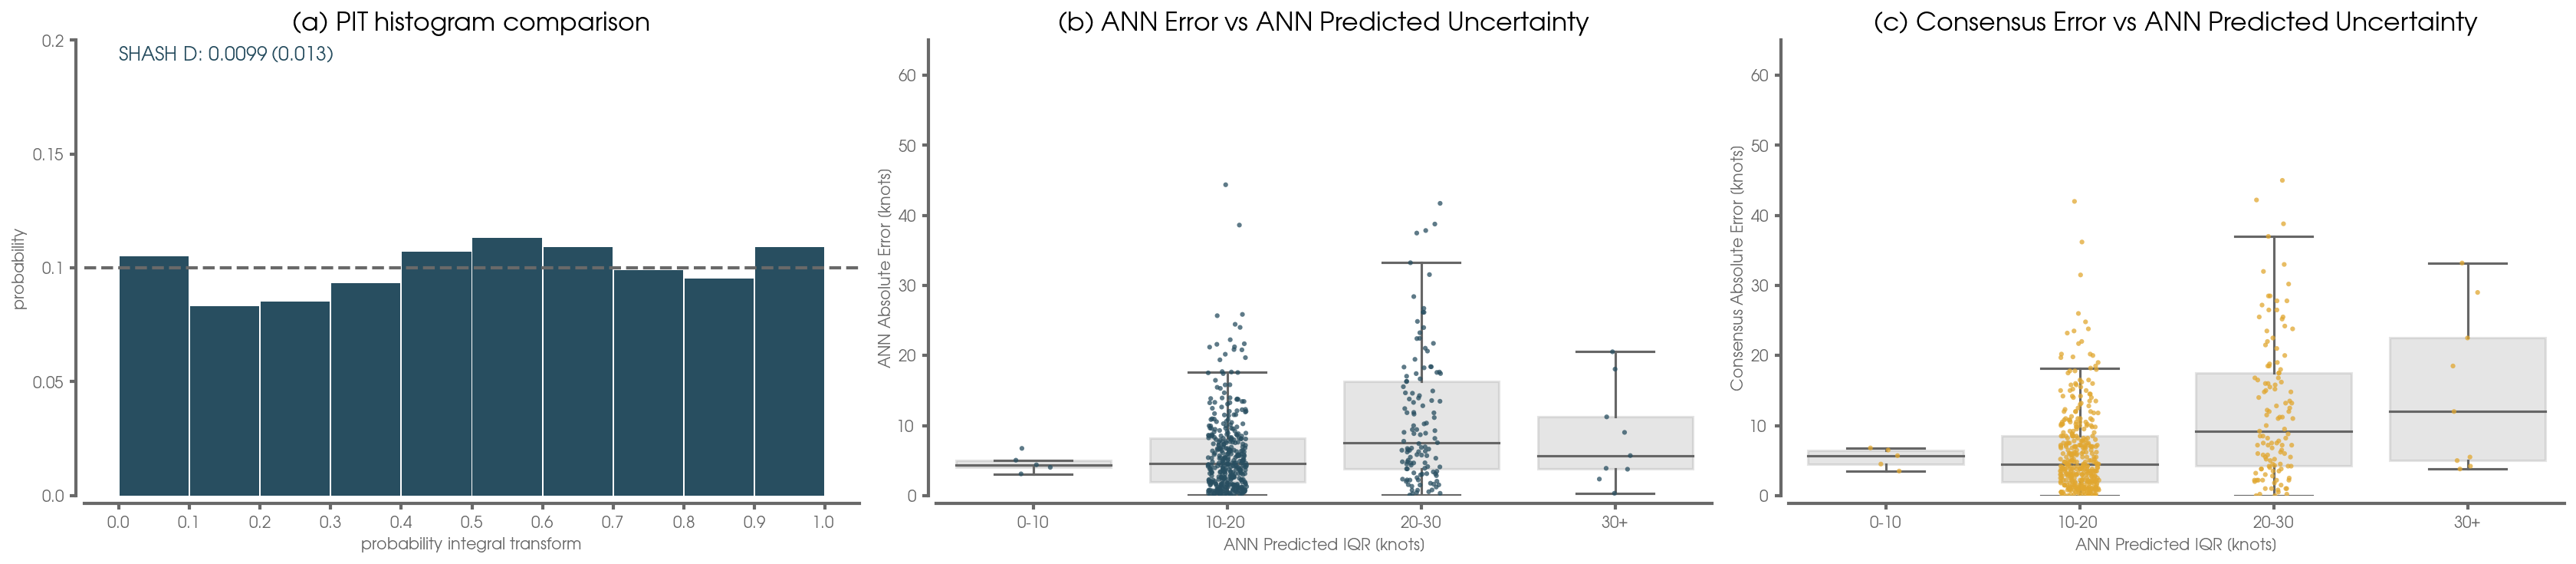

In [10]:
PLOT_DATA = '_valtest'
#------------------------------------------

if PLOT_DATA == '_valtest':
    x_eval = x_valtest
    onehot_eval = onehot_valtest
    df_eval = df_valtest
    pred_eval = pred_dict[EXP_NAME][RNG_SEED]['pred_cpd' + PLOT_DATA]    
elif PLOT_DATA == '_test':
    x_eval = x_test
    onehot_eval = onehot_test
    df_eval = df_test    
    pred_eval = pred_dict[EXP_NAME][RNG_SEED]['pred_cpd' + PLOT_DATA]    
else:
    raise NotImplementedError('no such PLOT_DATA')

imp.reload(analysis_plots)
f, axs = plt.subplots(1, 3, figsize=(15/2*3,5))

# plot sample
ax1 = axs[1]
plot_iqr_vs_error(ax1,model, x_eval, onehot_eval, df_eval, yvar="shash_error")
ax1.set_ylim(0,65)
ax1.set_yticks(np.arange(0,70,10),np.arange(0,70,10))
ax1.set_xticks((0,1,2,3))
ax1.set_xticklabels(['0-10','10-20','20-30','30+'])    
format_spines(ax1)

ax2 = axs[2]
plot_iqr_vs_error(ax2,model, x_eval, onehot_eval, df_eval, yvar="cons_error")
ax2.set_ylim(0,65)
ax2.set_yticks(np.arange(0,70,10),np.arange(0,70,10))
ax2.set_xticks((0,1,2,3))
ax2.set_xticklabels(['0-10','10-20','20-30','30+'])    
format_spines(ax2)

# plot PITS
ax = axs[0]
analysis_plots.plot_pits(ax, x_eval, onehot_eval, model, pred_eval, None)
plt.ylim(0,.2)
plt.title('(a) PIT histogram comparison', fontsize=FS, color='k')
format_spines(ax)

plt.tight_layout()
ax.get_legend().remove()
# plt.savefig(FIGURE_PATH + 'pit_error_iqr_' + model_name + '.png', dpi=dpiFig)    
plt.show()

## Plot case study

In [12]:
df_storm = df_test[df_test["Name"]==STORM_NAME]
df_storm = df_storm.sort_values(by="time")
istorm = df_storm.index
display(df_storm)

,ATCF,Name,year,time,ftime(hr),VMAX0,NCI,OBDV,DSDV,LGDV,...,EMDX,EGDX,HWDX,LONC,OBDY,AVDY,EMDY,EGDY,HWDY,LATC
196,AL09,ISAAC,2018,90800,24,30.0,4,10.5,3.5,0.5,...,18.8,18.8,8.1,36.7,2.8,-30.6,2.8,-19.4,47.2,14.4
142,AL09,ISAAC,2018,90806,24,30.0,4,15.5,3.5,1.5,...,-5.4,5.4,-26.8,37.5,-36.1,-47.2,30.6,-36.1,52.8,14.6
134,AL09,ISAAC,2018,90812,24,30.0,4,18.2,4.2,1.2,...,-29.5,13.4,-18.8,38.5,-61.1,-16.7,27.8,-38.9,27.8,14.9
33,AL09,ISAAC,2018,90818,24,35.0,4,15.8,6.8,4.8,...,10.7,-21.5,-32.2,39.6,-33.3,0.0,0.0,-33.3,33.3,14.7
110,AL09,ISAAC,2018,90900,24,45.0,4,6.8,4.8,8.8,...,21.5,-10.8,-43.0,40.9,-8.3,13.9,2.8,-41.7,25.0,14.6
214,AL09,ISAAC,2018,90906,24,45.0,4,8.2,6.2,7.2,...,-29.6,13.4,-8.1,41.9,-11.1,0.0,22.2,-33.3,11.1,14.6
200,AL09,ISAAC,2018,90912,24,55.0,4,-0.5,1.5,3.5,...,-37.7,26.9,16.1,43.2,0.0,11.1,11.1,-33.3,11.1,14.4
261,AL09,ISAAC,2018,90918,24,60.0,4,-1.8,4.2,7.2,...,-45.6,51.1,18.8,44.9,-47.2,41.7,8.3,-47.2,-2.8,14.8
257,AL09,ISAAC,2018,91000,24,65.0,4,-10.0,5.0,7.0,...,-72.4,56.4,34.9,46.0,-52.8,36.1,13.9,-52.8,2.8,15.0
65,AL09,ISAAC,2018,91006,24,65.0,4,-12.2,1.8,1.8,...,-56.3,61.8,8.1,47.1,-33.3,-22.2,55.5,-33.3,0.0,14.9


In [13]:
df_ri = pd.read_csv(PREDICTION_PATH + "shash3_bestValTestingPredictions.csv")
storm_ri = df_ri[(df_ri["Name"]==STORM_NAME) &
                 (df_ri["year"]==TESTING_YEAR) &
                 (df_ri["ftime(hr)"]==LEADTIME)
                ]
# storm_ri["Unnamed: 0"]
# storm_ri

# a = df_ri[df_ri["shash_pr_ri"]>.8]
# # plt.hist(a["shash_pr_ri"])
# # plt.hist(a["clim_pr_ri"])
# print(np.mean(a["shash_pr_ri"]), np.mean(a["clim_pr_ri"]))

# display(a)

In [15]:
true_intensity = df_test["VMXC"] + df_test["OBDV"]
cons_intensity = df_test["VMXC"]
t0max = df_test["VMAX0"]
y_pred = pred_dict[EXP_NAME][RNG_SEED]["pred_cpd_test"]
# SHASH_INCS+cons_intensity[sample],pred_dict[EXP_NAME][RNG_SEED]['pred_cpd_test'][sample,:],
y_pred.shape

(304, 321)

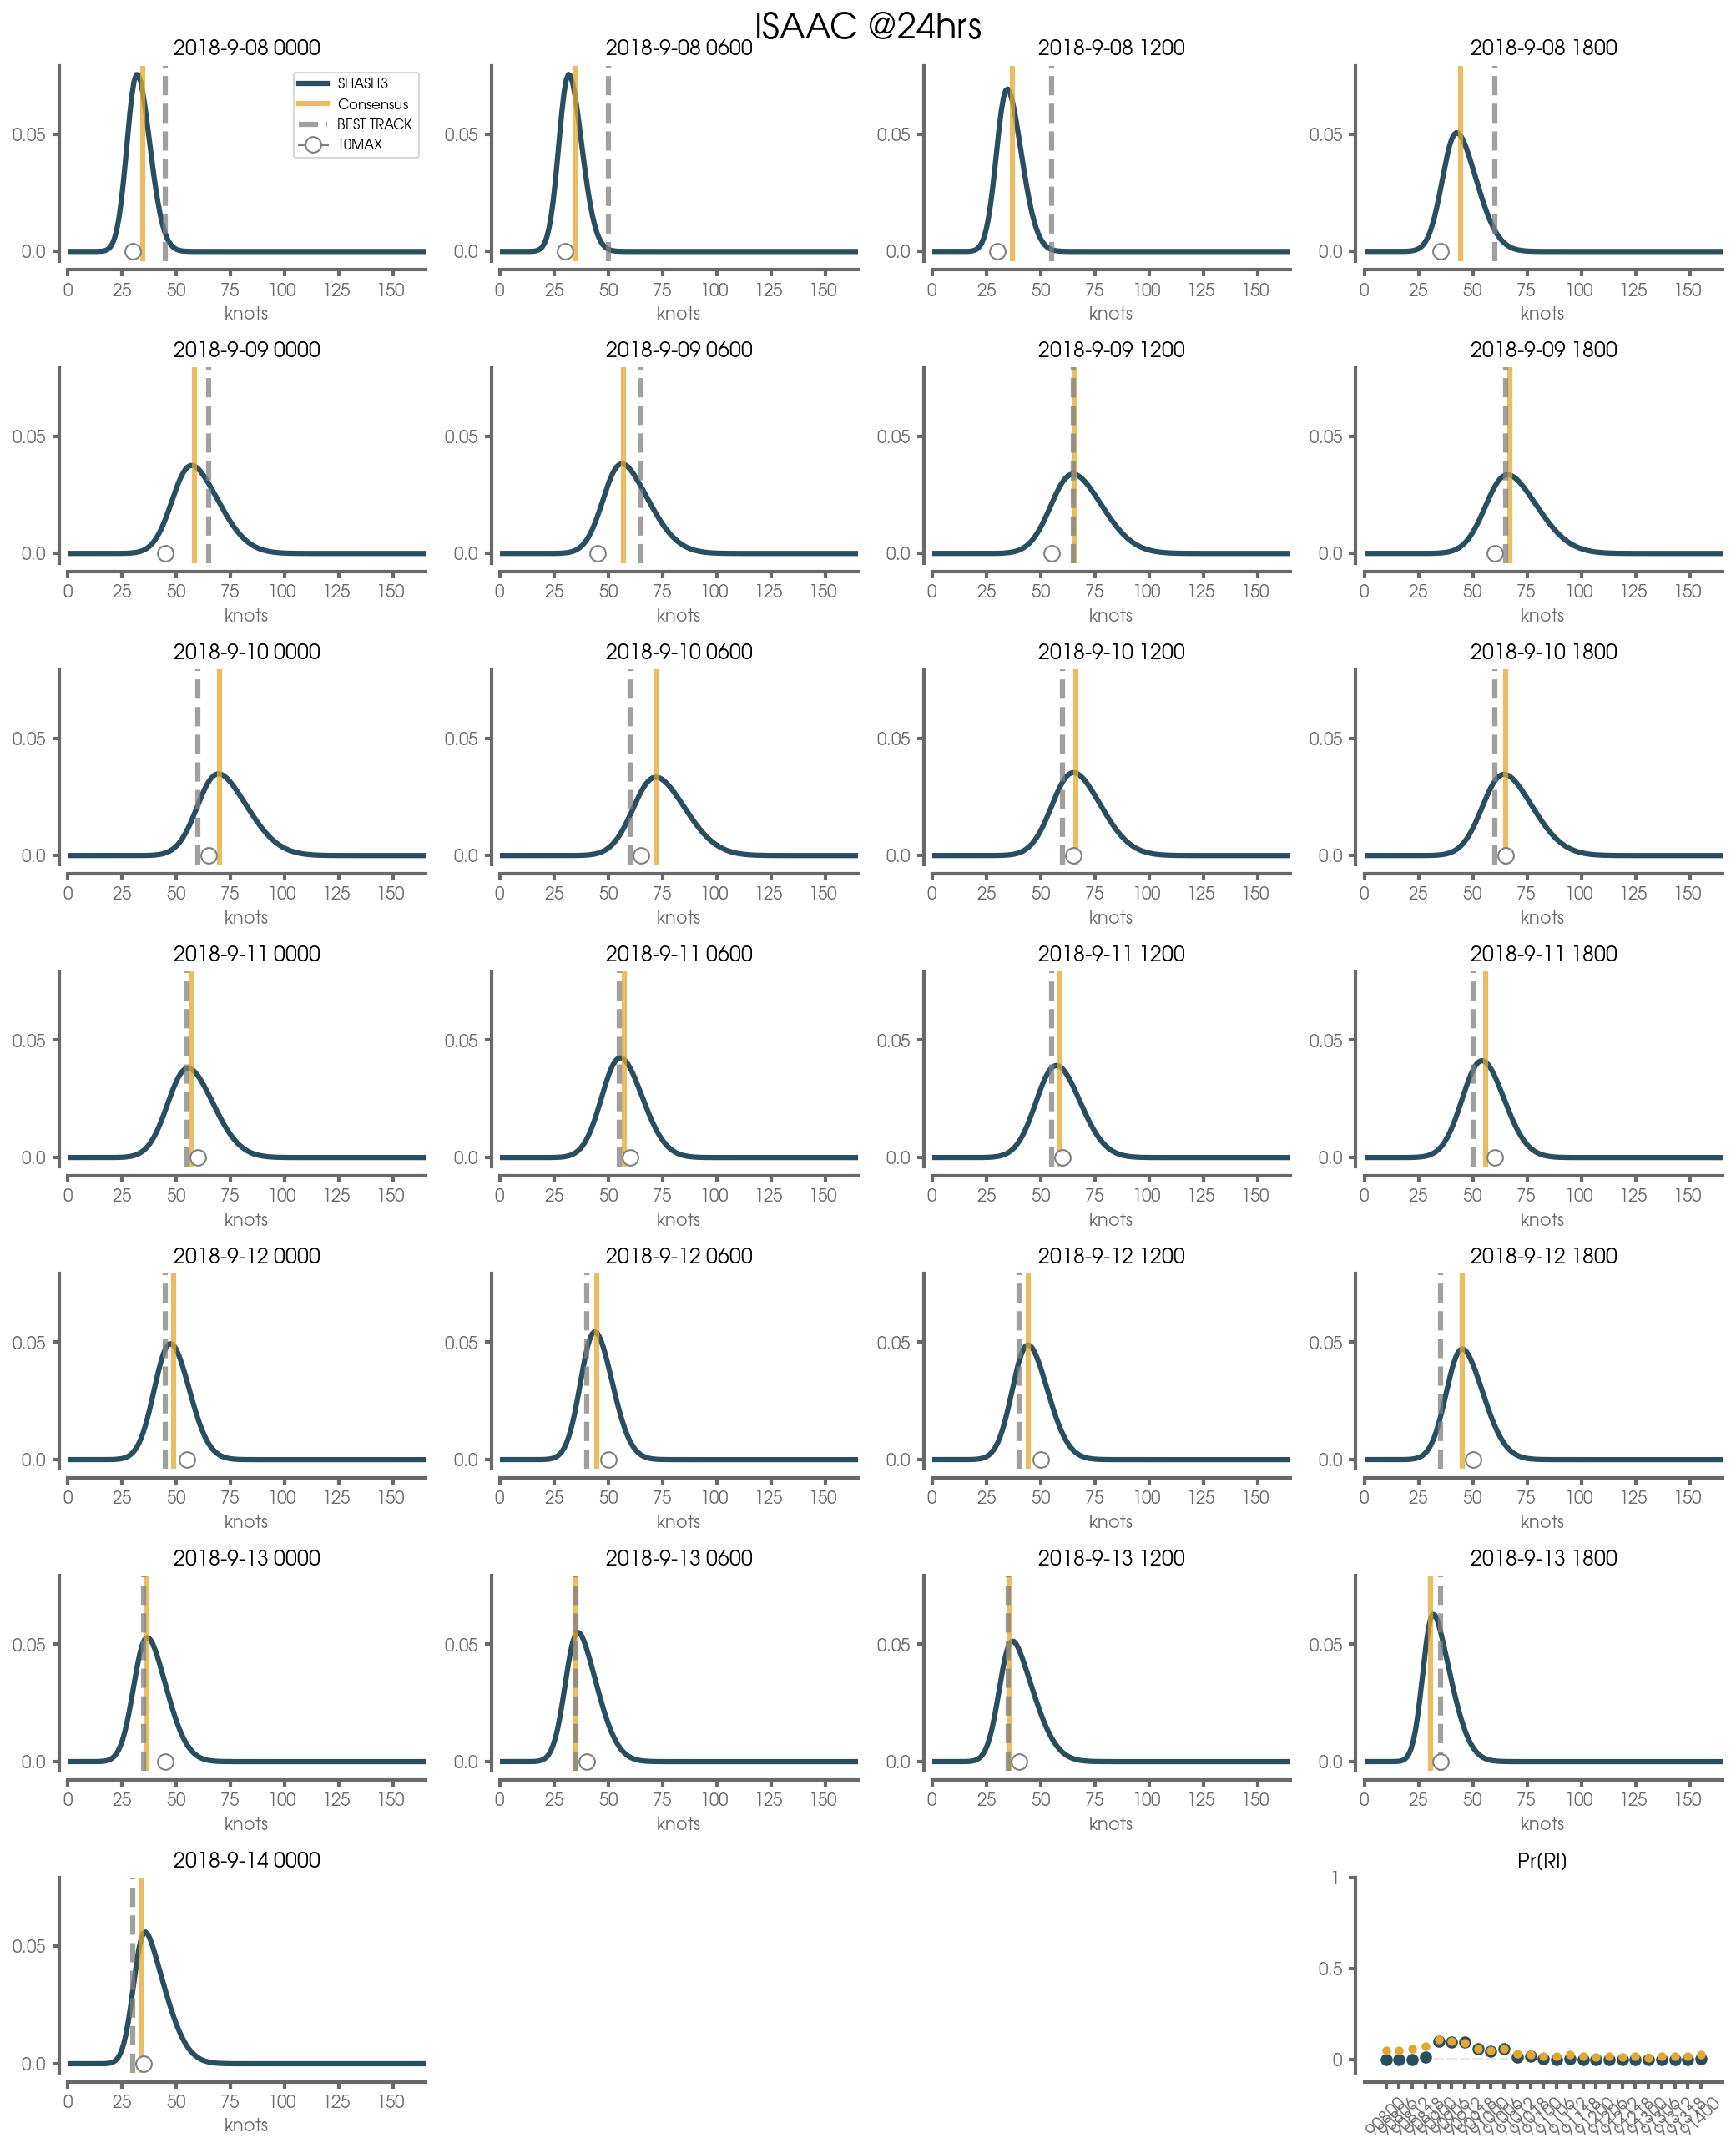

In [16]:
ncols = 4
nrows = int(np.ceil(len(istorm)/ncols))
fig, axs = plt.subplots(nrows,ncols,figsize=(3.5*ncols,nrows*2.5))
axs = axs.flatten()
ymax = 1.05*np.max(y_pred[istorm,:][:])

for iloop,index in enumerate(istorm):
        
    ax = axs[iloop]
    ax.plot(SHASH_INCS+cons_intensity[index],
            y_pred[index,:],
            color=colors[0],
            linewidth=3,
            label='SHASH3',
           )
    ax.axvline(x=cons_intensity[index],linestyle='-',color=colors[1],linewidth=3,alpha=.75,label='Consensus')       
    ax.axvline(x=true_intensity[index],linestyle='--',color='gray',linewidth=3,alpha=.75,label='BEST TRACK')    
    ax.plot(t0max[index],
            0.0,
            marker='o',
            markersize=9,
            linestyle=None,
            markerfacecolor='white',
            color='gray',
            label='T0MAX',
           )
    
    # set axes things
    ax.set_xlabel('knots')
    ax.set_xticks(np.arange(0,200,25),np.arange(0,200,25))
    ax.set_yticks(np.arange(0,.35,.05),np.arange(0,.35,.05).round(2)) 
    ax.set_ylim(-0.004,ymax)
    ax.set_xlim(0,165)                            
    details = get_storm_details(df_test,index)
    ax.set_title(details[len(STORM_NAME)+1:details.find('@')])
    format_spines(ax)
    
    
    # check if RI event
    try:
        if true_intensity[index] - t0max[index] >= RI_THRESH_DICT[LEADTIME]:
            ri_factor = 1.
        else:
            ri_factor = 0.01
        axs[-1].bar(x=iloop,
                    height=ri_factor,
                    color="gray",
                    edgecolor='white',
                    width=.8,
                    alpha=.25,
                   )        

        # plot RI probabilities
        axs[-1].plot(iloop,
                     storm_ri[storm_ri["Unnamed: 0"]==index]["shash_pr_ri"],
                     'o',
                     markersize=6,
                     color=colors[0],
                    )
        axs[-1].plot(iloop,
                     storm_ri[storm_ri["Unnamed: 0"]==index]["clim_pr_ri"],
                     'o',
                     markersize=4,
                     color=colors[1],
                    )  
    except:
        pass
for i in np.arange((iloop+1),(len(axs)-1)):
    axs[i].axis('off') 
    
# plot RI    
format_spines(axs[-1])
axs[-1].set_xticks(range(len(istorm)), 
                   df_test["time"][istorm],
                   rotation=45,
                  )
axs[-1].set_yticks((0,.5,1),(0,.5,1))
axs[-1].set_ylim(-0.075,1)
axs[-1].set_title('Pr[RI]')
    

axs[0].legend(fontsize=8) 
plt.suptitle(STORM_NAME + ' @' + str(LEADTIME) + 'hrs', fontsize=20)
plt.tight_layout()    
plt.savefig(FIGURE_PATH + 'caseStudy_' + model_name + '_' + STORM_NAME + '.png', dpi=dpiFig)